In [1]:
import pandas as pd
import numpy as np
import os
import os.path as osp
from tqdm.notebook import tqdm
import sys
sys.path.append('../../scripts')
import preprocessing.preprocessing as preprocessing
import matplotlib.pyplot as plt

In [2]:
# functions we use : 

# weekly variations

def isolate_weekdays(df: pd.DataFrame):
    """
    df - dataframe with daily data and a column where the day of the week was given as an integer 
    0 is Monday, 6 is Sunday
    """
    tmp = df[df['day_of_week'].apply(lambda x : x in [0,1,2,3,4])]
    tmp = preprocessing.resample(tmp,'1W')

    tmp['intra_weekday_returns'] = (tmp['close'] - tmp['open'])/tmp['open']
    
    return tmp

def isolate_weekends(df: pd.DataFrame):
    
    """
    df - dataframe with daily data and a column where the day of the week was given as an integer 
    0 is Monday, 6 is Sunday
    """
    
    tmp = df[df['day_of_week'].apply(lambda x : x not in [0,1,2,3,4])]
    tmp = preprocessing.resample(tmp,'1W')

    tmp['intra_weekend_returns'] = (tmp['close'] - tmp['open'])/tmp['open']
    
    return tmp

def calculate_weekly_price_vols(df: pd.DataFrame):
    """
    df - pandas dataframe ohlcv with a returns column
    """
    df = df.dropna()
    df['day_of_week'] = df.index.dayofweek
    tmp = df[df['day_of_week'].apply(lambda x : x in [0,1,2,3,4])]
    c = tmp.groupby(pd.Grouper(freq = 'W'))['returns'].apply(lambda x : np.std(x))
    return c 

# strategy - buy at the close of a particular weekday, sell over the weekend as soon as you make 
# more than the threshold return


def buy_at_weekday_check_weekend(df: pd.DataFrame,
                                 day_of_week: int,
                                 threshold: float):
    """
    df - daily price dataframe,
    day_of_week - int code of day of the week has to be between 0 and 4 (incl)
    threshold - float value which represents the minimum value over which we will sell
    """
    
    tmp = df[df['day_of_week'] == day_of_week]
    tmp = preprocessing.resample(tmp,'1W')

    df_1d_weekends = isolate_weekends(df)
    
    t = list(set(df_1d_weekends.index).intersection(set(tmp.index)))
    t.sort()
    
    df_1d_weekends = df_1d_weekends.loc[t]
    tmp = tmp.loc[t]
    
    diff  =  (df_1d_weekends['high'].values - tmp['close'].values)/(tmp['close'].values)
    
    success_rate = (diff > threshold).sum()/len(diff)
    
    return success_rate,diff
     
# Trying to figure out when this strategy fails by looking at the week that precedes an instance 
# when we can't make our 1 percent over the weekend. 

def what_happened_in_that_week(df: pd.DataFrame,s: str):
    t1 = pd.to_datetime(s)
    t0 = t1 - pd.Timedelta('6D')
    
    tmp = df.loc[t0:t1]
    tmp.close.plot()
    
    #tmptmp = tmp[tmp.day_of_week.apply(lambda x : x in [0,1,2,3,4])]
    #tmptmp.close.plot()
    
    f = (tmp.close[4] - tmp.close[0])/tmp.close[0]
    
    return f    

In [2]:
#df = pd.read_csv('../../data/data_new/raw/Binance/DOGE_USDT/DOGE_USDT.csv')

In [3]:
#def correct_csv():
#    root = '../../data/data_new/raw/Binance/'
#    for f in tqdm(os.listdir(root)):
#        if osp.isdir(osp.join(root,f)):
#            folder_name = osp.join(root,f)
#            path = folder_name + '/{}.csv'.format(f)
#            df = pd.read_csv(path)
#            df = df.drop('Unnamed: 0',axis = 1)
#            df.to_csv(path,index = False)

In [4]:
#correct_csv()

In [3]:
df = preprocessing.load_df('../../data/data_new/raw/Binance/BTC_USDT/BTC_USDT.csv')

Total NaN : 

timestamp    0
open         0
high         0
low          0
close        0
volume       0
returns      1
dtype: int64



In [6]:
df.loc['2018-02-10']

,timestamp,open,high,low,close,volume,returns
date,,,,,,,
2018-02-10 00:00:00,1518220800000,8683.93,8683.93,8650.00,8650.00,39.390029,-0.003906
2018-02-10 00:01:00,1518220860000,8661.89,8661.90,8640.48,8641.44,19.946281,-0.000990
2018-02-10 00:02:00,1518220920000,8644.93,8652.00,8634.28,8645.03,35.284595,0.000415
2018-02-10 00:03:00,1518220980000,8645.09,8668.00,8637.73,8645.98,17.211845,0.000110
2018-02-10 00:04:00,1518221040000,8636.15,8645.92,8604.08,8605.00,19.959248,-0.004740
...,...,...,...,...,...,...,...
2018-02-10 23:55:00,1518306900000,8516.76,8530.00,8514.00,8525.00,13.516443,0.000969
2018-02-10 23:56:00,1518306960000,8519.94,8520.00,8514.00,8519.75,9.339584,-0.000616
2018-02-10 23:57:00,1518307020000,8519.00,8522.00,8514.00,8515.00,8.133941,-0.000558


In [7]:
df_1d = preprocessing.resample(df,interval = '1D')

In [8]:
df_1d.iloc[0]

open        8683.930000
high        9065.780000
low         8120.000000
close       8533.980000
volume     49381.512653
returns       -0.017266
Name: 2018-02-10 00:00:00, dtype: float64

In [25]:
df_1d['dollar_volumes'] = (df_1d['volume']*(df_1d['close'] + df_1d['open'])/2)

In [26]:
df_1d['day_of_week'] = df_1d.index.dayofweek.tolist()

<AxesSubplot:xlabel='date'>

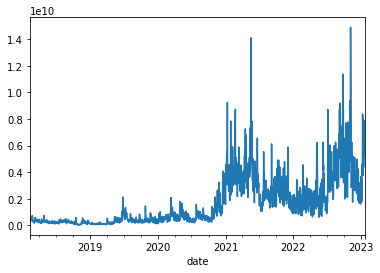

In [27]:
# Volumes go crazy in bull markets

df_1d['dollar_volumes'].plot()

<AxesSubplot:xlabel='date'>

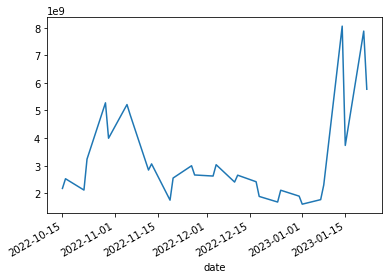

In [28]:
# IF we focus only on weekends, we get the same dollar volume increase and then if we zoom in to the last 30 days 
# we get a spike.

df_1d_only_weekends = df_1d[df_1d['day_of_week'].apply(lambda x: x in [5,6])]

df_1d_only_weekends[-30:].dollar_volumes.plot()

<AxesSubplot:xlabel='day_of_week'>

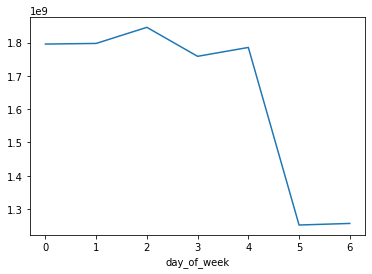

In [13]:
# Weekend dollar volumes fall of drastically !


df_1d.groupby('day_of_week').mean(lambda x : x.mean()).dollar_volumes.plot()

Basic question :

How do weekend volatilities change over time ?

How does trading on the weekend resemble trading in the week ? 

In [14]:
df_1d[df_1d['day_of_week'].apply(lambda x : x in [0,1,2,3,4])][:15]

,open,high,low,close,volume,returns,dollar_volumes,day_of_week
date,,,,,,,,
2018-02-12,8063.82,8989.00,8053.00,8903.00,41987.850490,0.104059,3.562002e+08,0
2018-02-13,8903.00,8950.00,8351.00,8539.90,35454.972956,-0.040784,3.092188e+08,1
2018-02-14,8535.17,9489.60,8533.00,9449.99,40811.952867,0.106569,3.670048e+08,2
2018-02-15,9449.98,10219.50,9301.50,10000.09,52427.596715,0.058212,5.098602e+08,3
2018-02-16,10000.89,10323.37,9666.00,10159.98,38161.205974,0.015989,3.846816e+08,4
2018-02-19,10375.01,11250.00,10270.33,11153.00,40831.417131,0.074115,4.395096e+08,0
2018-02-20,11147.11,11786.01,11100.59,11200.99,48153.354288,0.004303,5.380680e+08,1
2018-02-21,11195.07,11304.03,10200.00,10437.60,68113.818754,-0.068154,7.367419e+08,2
2018-02-22,10439.02,10933.44,9679.00,9811.04,67060.166483,-0.060029,6.789862e+08,3


In [16]:
# weekday variations 

#tmp = df_1d[df_1d['day_of_week'].apply(lambda x : x in [0,1,2,3,4])]
#tmp = preprocessing.resample(tmp,'1W')
#
#tmp['intra_week_returns'] = (tmp['close'] - tmp['open'])/tmp['open']


# weekend variations

#tmp1 = df_1d[df_1d['day_of_week'].apply(lambda x : x not in [0,1,2,3,4])]
#tmp1 = preprocessing.resample(tmp1,'1W')
#
#tmp1['intra_week_returns'] = (tmp1['close'] - tmp1['open'])/tmp1['open']

In [17]:
df_1d_weekdays = isolate_weekdays(df_1d)

df_1d_weekends = isolate_weekends(df_1d)

In [18]:
df_1d_weekends

,open,high,low,close,volume,dollar_volumes,returns,intra_weekend_returns
date,,,,,,,,
2018-02-18,10156.07,11274.00,10050.00,10383.43,103019.489135,1.098731e+09,0.287647,0.022387
2018-02-25,10131.04,10496.97,9274.80,9590.00,69261.673885,6.788998e+08,-0.076413,-0.053404
2018-03-04,11038.99,11565.00,11015.01,11515.00,38583.071933,4.382429e+08,0.200730,0.043121
2018-03-11,9230.00,9740.00,8450.00,9533.57,81505.986243,7.402909e+08,-0.172074,0.032889
2018-03-18,8260.00,8348.62,7322.00,8189.99,92598.438040,7.426078e+08,-0.140931,-0.008476
...,...,...,...,...,...,...,...,...
2022-12-25,16778.52,16869.99,16721.00,16832.11,225665.362980,3.796167e+09,0.005610,0.003194
2023-01-01,16607.48,16644.09,16470.00,16616.75,211415.842380,3.504624e+09,-0.012795,0.000558
2023-01-08,16950.31,17176.99,16908.00,17127.83,239682.465750,4.073898e+09,0.030757,0.010473


In [19]:
X = df_1d_weekdays[:-1].intra_weekday_returns

Y = df_1d_weekends[1:].intra_weekend_returns

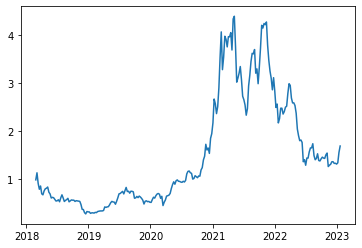

In [20]:
plt.plot((1 + X).cumprod())

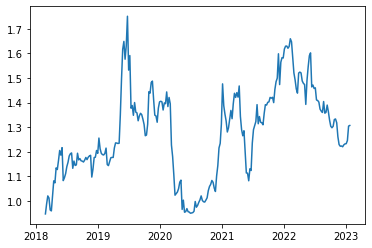

In [21]:
plt.plot((1 + Y).cumprod())

In [22]:
# very low correlation between what is happening in the week and what happens over the weekend

np.corrcoef(X,Y)

array([[1.        , 0.05914747],
       [0.05914747, 1.        ]])

In [24]:
# calculating weekly price volatility

c = calculate_weekly_price_vols(df)

/tmp/ipykernel_3576/3306260560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.dayofweek


In [68]:
# creating a filter where we focus only on those weeks where the activity was moderate

z = (c > np.percentile(c,30)) & (c < np.percentile(c,70))

In [27]:
np.corrcoef(X[z[2:]],Y[z[2:]]) #small negative corr

array([[1.        , 0.07469266],
       [0.07469266, 1.        ]])

<AxesSubplot:xlabel='date'>

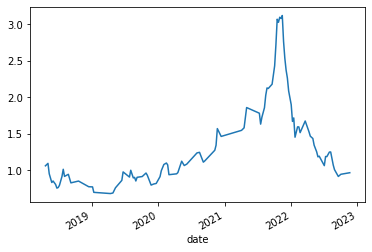

In [28]:
(1 + X[z[2:]]).cumprod().plot()

<AxesSubplot:xlabel='date'>

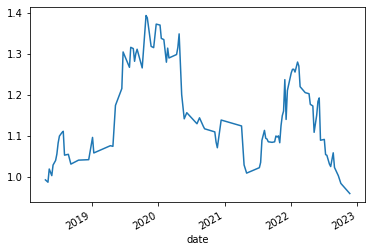

In [29]:
(1 + Y[z[2:]]).cumprod().plot()

In [30]:
z = (c > np.percentile(c,80)) 

In [31]:
np.corrcoef(X[z[2:]],Y[z[2:]]) # This seems pretty amazing ! 

array([[ 1.        , -0.02859819],
       [-0.02859819,  1.        ]])

In [32]:
# Maybe we need to understand intra week returns data better

In [33]:
df_1d[df_1d['day_of_week'] == 3]['close']

date
2018-02-15    10000.09
2018-02-22     9811.04
2018-03-01    10920.00
2018-03-08     9271.64
2018-03-15     8240.98
                ...   
2022-12-22    16821.43
2022-12-29    16633.47
2023-01-05    16831.85
2023-01-12    18846.62
2023-01-19    21071.59
Freq: 7D, Name: close, Length: 258, dtype: float64

In [34]:
df_1d_weekend = df_1d[df_1d['day_of_week'].apply(lambda x : x in [5,6])]

In [35]:
tmp1['high']

date
2018-02-18    11274.00
2018-02-25    10496.97
2018-03-04    11565.00
2018-03-11     9740.00
2018-03-18     8348.62
                ...   
2022-12-25    16869.99
2023-01-01    16644.09
2023-01-08    17176.99
2023-01-15    21258.00
2023-01-22    23371.80
Freq: W-SUN, Name: high, Length: 258, dtype: float64

In [36]:
(df_1d[df_1d['day_of_week'] == 4]['close'].values < tmp1['high'].values).sum()

258

In [37]:
198/258

0.7674418604651163

In [38]:
diff  =  (tmp1['high'].values - df_1d[df_1d['day_of_week'] == 4]['close'].values)/(df_1d[df_1d['day_of_week'] == 4]['close'].values)


In [39]:
np.percentile(diff,25)

0.011509725160422623

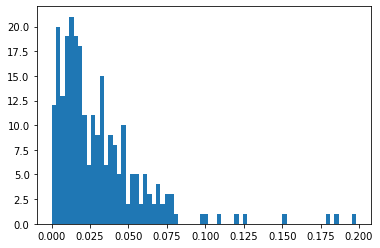

In [40]:
plt.hist(diff,bins = 70)
plt.xlabel
plt.show()

In [41]:
(diff > 0.01).sum()/258

0.7984496124031008

In [42]:
df_1d[df_1d['day_of_week'] == 4]['close']

date
2018-02-16    10159.98
2018-02-23    10131.04
2018-03-02    11039.00
2018-03-09     9227.00
2018-03-16     8260.00
                ...   
2022-12-23    16778.50
2022-12-30    16607.48
2023-01-06    16950.65
2023-01-13    19930.01
2023-01-20    22667.21
Freq: 7D, Name: close, Length: 258, dtype: float64

,timestamp,open,high,low,close,volume,returns
date,,,,,,,
2023-01-06 00:00:00,1672963200000,16831.85,16833.89,16830.44,16830.47,114.02537,-0.000082
2023-01-06 00:01:00,1672963260000,16830.83,16834.82,16828.55,16832.91,140.08173,0.000145
2023-01-06 00:02:00,1672963320000,16833.35,16833.56,16828.55,16829.52,143.23319,-0.000201
2023-01-06 00:03:00,1672963380000,16829.52,16832.14,16827.04,16832.04,126.99689,0.000150
2023-01-06 00:04:00,1672963440000,16832.03,16832.07,16827.08,16828.06,60.13812,-0.000236
...,...,...,...,...,...,...,...
2023-01-06 23:55:00,1673049300000,16951.79,16955.60,16951.16,16954.20,69.70818,0.000129
2023-01-06 23:56:00,1673049360000,16954.20,16955.29,16950.61,16951.54,91.12506,-0.000157
2023-01-06 23:57:00,1673049420000,16951.54,16952.31,16950.02,16950.89,40.59416,-0.000038


In [82]:
df_1d_weekdays = isolate_weekdays(df_1d)

df_1d_weekends = isolate_weekends(df_1d)

In [105]:
t = list(set(df_1d_weekends.index).intersection(set(df_1d_weekdays.index)))
t.sort()

In [108]:
#df_1d_weekends.loc[t]

In [110]:
#df_1d_weekdays.loc[t]

In [111]:
df_1d_weekends['high']

date
2018-02-18    11274.00
2018-02-25    10496.97
2018-03-04    11565.00
2018-03-11     9740.00
2018-03-18     8348.62
                ...   
2022-12-25    16869.99
2023-01-01    16644.09
2023-01-08    17176.99
2023-01-15    21258.00
2023-01-22    23371.80
Freq: W-SUN, Name: high, Length: 258, dtype: float64

In [117]:
df_1d[df_1d['day_of_week'] == 4]

,open,high,low,close,volume,returns,dollar_volumes,day_of_week
date,,,,,,,,
2018-02-16,10000.89,10323.37,9666.00,10159.98,38161.205974,0.015989,3.846816e+08,4
2018-02-23,9815.55,10435.00,9570.19,10131.04,57202.702370,0.032616,5.704994e+08,4
2018-03-02,10923.36,11200.00,10770.00,11039.00,23910.710090,0.010897,2.625678e+08,4
2018-03-09,9267.07,9410.00,8329.00,9227.00,64112.291407,-0.004815,5.928486e+08,4
2018-03-16,8240.98,8611.64,7900.00,8260.00,38815.409893,0.002308,3.202462e+08,4
...,...,...,...,...,...,...,...,...
2022-12-23,16821.90,16955.14,16731.13,16778.50,161612.009470,-0.002552,2.715114e+09,4
2022-12-30,16633.47,16677.35,16333.00,16607.48,164916.311740,-0.001563,2.740987e+09,4
2023-01-06,16831.85,17041.00,16679.00,16950.65,207401.284150,0.007058,3.503267e+09,4


In [116]:
preprocessing.resample(df_1d[df_1d['day_of_week'] == 4],'1W')


,open,high,low,close,volume,dollar_volumes,returns
date,,,,,,,
2018-02-25,9815.55,10435.00,9570.19,10131.04,57202.702370,5.704994e+08,-0.002848
2018-03-04,10923.36,11200.00,10770.00,11039.00,23910.710090,2.625678e+08,0.089622
2018-03-11,9267.07,9410.00,8329.00,9227.00,64112.291407,5.928486e+08,-0.164145
2018-03-18,8240.98,8611.64,7900.00,8260.00,38815.409893,3.202462e+08,-0.104801
2018-03-25,8720.00,8909.00,8269.00,8898.03,39991.007666,3.522814e+08,0.077243
...,...,...,...,...,...,...,...
2022-12-25,16821.90,16955.14,16731.13,16778.50,161612.009470,2.715114e+09,0.008801
2023-01-01,16633.47,16677.35,16333.00,16607.48,164916.311740,2.740987e+09,-0.010193
2023-01-08,16831.85,17041.00,16679.00,16950.65,207401.284150,3.503267e+09,0.020664


In [135]:
for k in range(5):
    s,d= buy_at_weekday_check_weekend(df_1d,k,0.01)
    print(k,s)

0 0.5836575875486382
1 0.5953307392996109
2 0.6070038910505836
3 0.6575875486381323
4 0.7976653696498055


In [148]:
bad_dates = [i for i in range(len(d)) if d[i] < 0.01]

In [153]:
day_of_week = 4

tmp = df_1d[df_1d['day_of_week'] == day_of_week]
tmp = preprocessing.resample(tmp,'1W')

df_1d_weekends = isolate_weekends(df_1d)

t = list(set(df_1d_weekends.index).intersection(set(tmp.index)))
t.sort()

df_1d_weekends = df_1d_weekends.loc[t]
tmp = tmp.loc[t]

In [194]:
idx = (tmp.iloc[bad_dates].index)

2021-12-26 00:00:00


0.08325503430094446

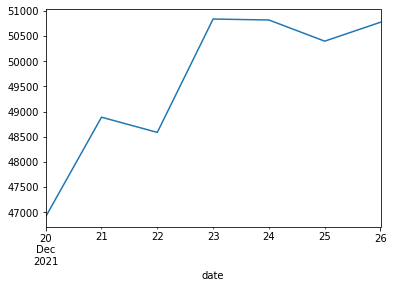

In [214]:
c = 35

print(idx[c])

what_happened_in_that_week(df_1d,idx[c])

Things to be aware of : 

1. big decreases in the week 
2. close to an all time low
3. big increase in the week 
4. how close to an ATH


Next step is to predict weekend lows using weekly data. 

features : long term trends, variation in the week, drawdowns in the week, big increases in the week, weekly volume data, how close to ATH, how close to ATL (percent terms)   

In [85]:
df['day_of_week'] = df.index.dayofweek

In [86]:
tmp1 = df[df['day_of_week'] == 4]


#tmp1['time'] = tmp1[(tmp1['day_of_week'] == 4)].index.time

In [87]:
tmp1[(tmp1.index.hour == 23) & (tmp1.index.minute == 59)]

,timestamp,open,high,low,close,volume,returns,day_of_week
date,,,,,,,,
2018-02-09 23:59:00,1518220740000,8690.45,8701.30,8683.92,8683.92,15.297334,-0.000736,4
2018-02-16 23:59:00,1518825540000,10156.03,10160.01,10146.00,10159.98,17.938177,0.000389,4
2018-02-23 23:59:00,1519430340000,10156.38,10159.99,10131.04,10131.04,11.209416,-0.001870,4
2018-03-02 23:59:00,1520035140000,11025.87,11039.00,11023.00,11039.00,5.768759,0.001191,4
2018-03-09 23:59:00,1520639940000,9225.00,9232.00,9224.00,9227.00,15.827283,0.000217,4
...,...,...,...,...,...,...,...,...
2022-12-23 23:59:00,1671839940000,16778.77,16780.74,16777.81,16778.50,39.838660,-0.000029,4
2022-12-30 23:59:00,1672444740000,16607.88,16609.84,16607.23,16607.48,40.139110,-0.000024,4
2023-01-06 23:59:00,1673049540000,16950.80,16952.15,16950.19,16950.65,36.788940,0.000013,4


In [88]:
df[df['day_of_week'].apply(lambda x : x in [5,6])]

,timestamp,open,high,low,close,volume,returns,day_of_week
date,,,,,,,,
2018-02-10 00:00:00,1518220800000,8683.93,8683.93,8650.00,8650.00,39.390029,-0.003906,5
2018-02-10 00:01:00,1518220860000,8661.89,8661.90,8640.48,8641.44,19.946281,-0.000990,5
2018-02-10 00:02:00,1518220920000,8644.93,8652.00,8634.28,8645.03,35.284595,0.000415,5
2018-02-10 00:03:00,1518220980000,8645.09,8668.00,8637.73,8645.98,17.211845,0.000110,5
2018-02-10 00:04:00,1518221040000,8636.15,8645.92,8604.08,8605.00,19.959248,-0.004740,5
...,...,...,...,...,...,...,...,...
2023-01-22 23:55:00,1674431700000,22730.65,22734.05,22723.13,22727.20,69.752750,-0.000152,6
2023-01-22 23:56:00,1674431760000,22727.18,22733.38,22711.58,22714.15,87.304610,-0.000574,6
2023-01-22 23:57:00,1674431820000,22714.06,22715.18,22698.65,22707.04,82.070630,-0.000313,6


In [99]:
s = (-df_1d_weekends['open'] + df_1d_weekends['low'])/(df_1d_weekends['open'])

<AxesSubplot:>

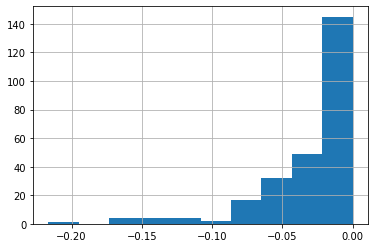